# Dynamic Mode Decomposition benchmark
A very basic benchmark to understand how to tune DMD Deep Learning pipelines for the best performance.

In [4]:
import time

from data import data_maker_fluid_flow_full

import matplotlib.pyplot as plt
import torch
from torch.profiler import profile, record_function, ProfilerActivity
import numpy as np

from pydmd import DMD

In [2]:
repeats = 10
mininbatch_size = [256, 512, 1024, 2048, 5096, 10192]

### Experiments
- Non-tensorized DMD (i.e. no batch dimension, implemented with loop) -- NumPy implementation
- Non-tensorized DMD (i.e. no batch dimension, implemented with loop) -- PyTorch implementation
- Tensorized DMD (with batch dimension) on CPU
- Tensorized DMD on GPU

### DMD variant
We consider the standard DMD variant from `Kutz, J. Nathan, et al. Dynamic mode decomposition: data-driven modeling of complex systems. Society for Industrial and Applied Mathematics, 2016.`

### Hardware
- Host: `agnesi.maths.sissa.it`
- CPU: `11th Gen Intel(R) Core(TM) i7-11700 @ 2.50GHz`
- GPU: `NVIDIA Quadro RTX 4000`

### Software
- NumPy: `1.22.0`
- PyTorch: `1.13.1`
- CUDA: `cuda/11.7`

In [5]:
nontensorized_cpu_numpy = []
nontensorized_cpu = []
tensorized_cpu = []
tensorized_gpu = []

for size in mininbatch_size:
    print(f'---- {size} ----')
    data = data_maker_fluid_flow_full(
        x1_lower=-1.1,
        x1_upper=1.1,
        x2_lower=-1.1,
        x2_upper=1.1,
        x3_lower=0.0,
        x3_upper=2,
        n_ic=size,
        dt=0.01,
        tf=6,
    ).swapaxes(-1, -2).astype(np.float32)
    print(data.shape, data.dtype)
    
    m = 100000000000000
    for repeat in range(repeats):
        start = time.time_ns()
        dmd = DMD(svd_rank=-1)
        for instance in data:
            dmd.fit(instance)
        elapsed = time.time_ns() - start
        m = min(m, elapsed)
    nontensorized_cpu_numpy.append(m / 1_000_000)
    print('nonbatch-cpu NumPy done')
    
    data = torch.from_numpy(data)
    
    m = 100000000000000
    for repeat in range(repeats):
        start = time.time_ns()
        dmd = DMD(svd_rank=-1)
        for instance in data:
            dmd.fit(instance)
        elapsed = time.time_ns() - start
        m = min(m, elapsed)
    nontensorized_cpu.append(m / 1_000_000)
    print('nonbatch-cpu done')
        
    m = 100000000000000
    for repeat in range(repeats):
        start = time.time_ns()
        dmd = DMD(svd_rank=-1)
        dmd.fit(data)
        elapsed = time.time_ns() - start
        m = min(m, elapsed)
    tensorized_cpu.append(m / 1_000_000)
    print('batch-cpu done')
    
    data = data.cuda()
    print('moved to GPU')
    
    m = 100000000000000
    for repeat in range(repeats):
        start = time.time_ns()
        dmd = DMD(svd_rank=-1)
        dmd.fit(data)
        elapsed = time.time_ns() - start
        m = min(m, elapsed)
    tensorized_gpu.append(m / 1_000_000)
    print('batch-gpu done')

---- 256 ----
(256, 3, 601) float32
nonbatch-cpu NumPy done
nonbatch-cpu done
batch-cpu done
moved to GPU
batch-gpu done
---- 512 ----
(512, 3, 601) float32
nonbatch-cpu NumPy done
nonbatch-cpu done
batch-cpu done
moved to GPU
batch-gpu done
---- 1024 ----
(1024, 3, 601) float32
nonbatch-cpu NumPy done
nonbatch-cpu done
batch-cpu done
moved to GPU
batch-gpu done
---- 2048 ----
(2048, 3, 601) float32
nonbatch-cpu NumPy done
nonbatch-cpu done
batch-cpu done
moved to GPU
batch-gpu done
---- 5096 ----
(5096, 3, 601) float32
nonbatch-cpu NumPy done
nonbatch-cpu done
batch-cpu done
moved to GPU
batch-gpu done
---- 10192 ----
(10192, 3, 601) float32
nonbatch-cpu NumPy done
nonbatch-cpu done
batch-cpu done
moved to GPU
batch-gpu done


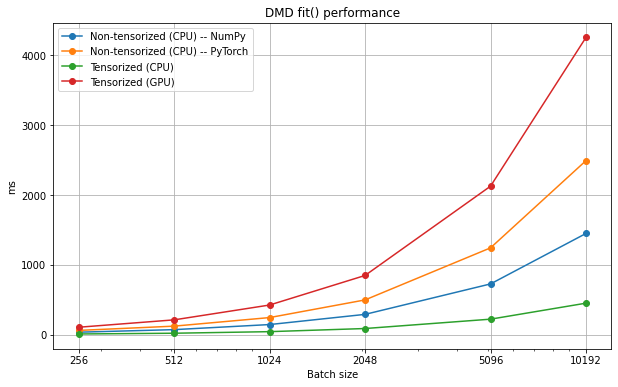

In [7]:
plt.figure(figsize=(10,6))

plt.title('DMD fit() performance')
plt.grid()
plt.xscale('log')

plt.plot(mininbatch_size, nontensorized_cpu_numpy, '-o', label='Non-tensorized (CPU) -- NumPy')
plt.plot(mininbatch_size, nontensorized_cpu, '-o', label='Non-tensorized (CPU) -- PyTorch')
plt.plot(mininbatch_size, tensorized_cpu, '-o', label='Tensorized (CPU)')
plt.plot(mininbatch_size, tensorized_gpu, '-o', label='Tensorized (GPU)')

plt.xticks(mininbatch_size, mininbatch_size)
plt.xlabel('Batch size')
plt.ylabel('ms')

plt.legend()

plt.show()

## Results interpretation
- We'd better do pre/post processing on GPU if needed, but DMD should definitely stay on CPU. 
    - In case we manage to reduce dimensionality we could reduce the memory movement cost.
- Tensorized DMD is much more performant wrt its `for`-loop counterpart (by at least 1 order of magnitude)

## Profiling
We turn to PyTorch profiler to understand what's happening on GPU due to the (kind of) unsurprisingly bad performance.

In [ ]:
data = data_maker_fluid_flow_full(
        x1_lower=-1.1,
        x1_upper=1.1,
        x2_lower=-1.1,
        x2_upper=1.1,
        x3_lower=0.0,
        x3_upper=2,
        n_ic=1024,
        dt=0.01,
        tf=6,
    )
data = torch.from_numpy(data).swapaxes(-1, -2)
data = data.to(dtype=torch.float32, device='cuda')

dmd = DMD(svd_rank=-1)
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True, with_stack=True) as prof:
    with record_function("model_inference"):
        dmd.fit(data)

In [ ]:
with open("profiler.txt", "w") as f:
    f.write(prof.key_averages(group_by_stack_n=1).table(sort_by="cuda_time_total", row_limit=20))

The profiler clearly highlights that the culprits are `torch.linalg.svd` and `torch.linalg.cond`.